In [1]:
#import requests
import pandas as pd 
import numpy as np
import lazop_sdk as lazop
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install lazop-sdk

## Подключение к API Lazada

In [2]:
appSecret = ''
appkey = ''
url = 'https://api.lazada.sg/rest'
# access_token = '50000200a15NOd9iBOXQThf6iYD179edf45ppETweAfbSAsrXcGHJm2jvVeu7fUs'

In [3]:
client = lazop.LazopClient(url, appkey ,appSecret)
request = lazop.LazopRequest('/category/tree/get','GET')
request.add_api_param('language_code', 'en_US')
response = client.execute(request)
print(response.type)
dict_laz = response.body

None


In [4]:
dict_1 = dict_laz.pop('data') 


## Загрузить данные и изучить общую информацию

| Field Name  | Field Description| 
| :---    | :----    | 
| children    | List of subcategories of the current category ID |
| name    | Category Name |
| leaf    | Determine if the category is a leaf category, only leaf categories can be used to create products |
| category_id    | The ID of the current category, used when creating products or getting category attributes |



Данные имеют вид вложенных словарей и списков словарей, поэтому для начала стоит извлечь из них данные и загрузить все в ДФ. Всего уровней подкатегорий 6.

In [5]:
def dict_open(new_dict, ff, dict_1, dict_key):
    
    for i in range(len(dict_1)):
        for j in list(dict_1[i].keys()):
            
            if j == dict_key:
                
                ff.append(dict_1[i][j])
                
        new_dict.append({key:dict_1[i][key] for key in dict_1[i] if key != dict_key})
        
    return [ff, new_dict] 

In [6]:
def dict_open_1(new_dict, ff, dict_1, dict_key):
    
    for i in range(len(dict_1)):
        for k in range(len(dict_1[i])):
            for j in list(dict_1[i][k].keys()):
                
                if j == dict_key:
                    
                    ff.append(dict_1[i][k][j])
                    
            new_dict.append({key:dict_1[i][k][key] for key in dict_1[i][k] if key != dict_key})
            
    return [ff, new_dict]

In [7]:
ff_1, new_dict_1 = dict_open([], [], dict_1, 'children')

In [8]:
while ff_1 != []:
    ff_1, new_dict_1 = dict_open_1(new_dict_1, [], ff_1, 'children')

In [9]:
len(new_dict_1)

5212

In [10]:
len(ff_1)

0

In [11]:
df_categ = pd.DataFrame(columns=['var', 'name', 'leaf', 'category_id'])

for i in range(len(new_dict_1)):
    df_categ = df_categ.append(new_dict_1[i], ignore_index=True)

In [12]:
df_categ = df_categ.sort_values(by='category_id').reset_index(drop=True)

In [13]:
df_categ.head()

,var,name,leaf,category_id
0,False,Mobiles & Tablets,False,2
1,False,Smartphones,True,3
2,False,Tablets,True,7
3,False,Landline Phones,True,49
4,False,Computers & Laptops,False,54


In [14]:
df_categ['name'] = df_categ['name'].str.lower()

Дальнейший анализ для атрибутов буду проводить не для всех категорий, а для тех, которые имеют в своем составе несколько category_id. Но чтобы передать для дальнейшей работы чистые данные, то для начала проведу крвткиц анализ для df_categ - посмотрю дубликаты, пропуски, проверю типы данных.

In [15]:
def data_fr(df):
    display(df.head(10))
    print(2 * "\n")
    display(df.info())
    print(2 * "\n")
    display(df.describe().T)
    print(2 * "\n")
    print('Кол-во нулей:')
    display(df.isnull().sum())
    print(2 * "\n")
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')

In [16]:
data_fr(df_categ)

,var,name,leaf,category_id
0,False,mobiles & tablets,False,2
1,False,smartphones,True,3
2,False,tablets,True,7
3,False,landline phones,True,49
4,False,computers & laptops,False,54
5,False,laptops,False,55
6,False,traditional laptops,True,57
7,False,gaming laptops,True,58
8,False,desktops computers,False,61
9,False,computer accessories,False,78





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   var          5212 non-null   object
 1   name         5212 non-null   object
 2   leaf         5212 non-null   object
 3   category_id  5212 non-null   object
dtypes: object(4)
memory usage: 163.0+ KB


None

,count,unique,top,freq
var,5212,2,False,4995
name,5212,4361,accessories,31
leaf,5212,2,True,4458
category_id,5212,5212,10100736,1





Кол-во нулей:


var            0
name           0
leaf           0
category_id    0
dtype: int64




Кол-во дубликатов: 0


Всего получено 5212 категорий, из них самые многочисленные - accessories (31 category_id). Чаще всего категории являются конечными категориями и пригодны для добавления продуктов. Все category_id уникальны.

Данные чистые, пропусков и дубликатов нет, тип данных подходит для обработки.

In [17]:
categories_name = list(df_categ.groupby('name')['category_id'].nunique().sort_values(ascending=False)[lambda x: x>1].index)

In [18]:
categories = list(df_categ.query('name == @categories_name')['category_id'])
len(categories)

1301

Далее сделаю запрос GetCategoryAttributes для выбранных category_id из categories, сохраню все в df и в файл 'top_categ_2023.csv', чтобы каждый раз не выполнять запросы. 

In [19]:
appSecret = 'xxx'
appkey = 'xxx'
url = 'https://api.lazada.sg/rest'
access_token = '50000200335beFqacuQDuhimSZnrZddFvciybsPjYiFUePV13ae35cdVEI8brSJu'

In [20]:
df = pd.DataFrame()


#for j in accessories:
for j in categories:    

    client = lazop.LazopClient(url, appkey ,appSecret)
    request = lazop.LazopRequest('/category/attributes/get','GET')
    request.add_api_param('primary_category_id', j)
    request.add_api_param('language_code', 'en_US')
    response = client.execute(request)
    response.type
    laz = response.body

    if response.type == None:
        
        dict_item = laz.pop('data')
        ff_2, dict_items = dict_open([], [], dict_item, 'advanced')

        
        for i in range(len(dict_items)):
            
            dict_items[i]['category_id'] = j
            df = df.append(dict_items[i], ignore_index=True)


df.to_csv('top_categ_2023.csv', index=False) 

## Выполнить базовый анализ данных и сделать общие выводы 

<b> 3.1. Изучить общую информацию о датасетах.

Провести предобработку - кол-во дубликатов, типы данных, пропуски, размерности.</b> 

In [21]:
df = pd.read_csv('top_categ_2023.csv')

Для дальнейшего удобства, добавлю к df еще имена категорий из df_categ.

In [22]:
df.head()

,attribute_type,category_id,id,input_type,is_mandatory,is_sale_prop,label,name,options
0,normal,7.0,1.0,text,1.0,0.0,Name,name,NaN
1,normal,7.0,4.0,richText,0.0,0.0,Long Description (Lorikeet),description,NaN
2,normal,7.0,5.0,text,0.0,0.0,Video URL,video,NaN
3,normal,7.0,30849.0,singleSelect,0.0,0.0,Expandable Memory,expandable_memory,"[{'name': 'Yes', 'en_name': 'Yes', 'id': 2110}..."
4,normal,7.0,30850.0,singleSelect,0.0,0.0,Cellular,tablet_cellular,"[{'name': 'Yes', 'en_name': 'Yes', 'id': 2110}..."


In [23]:
df = df.merge(df_categ[['name','category_id']], on='category_id', suffixes=('_attribute', '_category'))

Переведу некоторые столбцы к нижнему регистру, чтобы не пропустить дубли.

In [24]:
data_fr(df)

,attribute_type,category_id,id,input_type,is_mandatory,is_sale_prop,label,name_attribute,options,name_category
0,normal,7.0,1.0,text,1.0,0.0,Name,name,NaN,tablets
1,normal,7.0,4.0,richText,0.0,0.0,Long Description (Lorikeet),description,NaN,tablets
2,normal,7.0,5.0,text,0.0,0.0,Video URL,video,NaN,tablets
3,normal,7.0,30849.0,singleSelect,0.0,0.0,Expandable Memory,expandable_memory,"[{'name': 'Yes', 'en_name': 'Yes', 'id': 2110}...",tablets
4,normal,7.0,30850.0,singleSelect,0.0,0.0,Cellular,tablet_cellular,"[{'name': 'Yes', 'en_name': 'Yes', 'id': 2110}...",tablets
5,normal,7.0,30851.0,enumInput,0.0,0.0,Screen Size (inches),display_size_tablet,NaN,tablets
6,normal,7.0,120013475.0,enumInput,0.0,0.0,Plug Type,Plug_Type,"[{'name': 'Universal', 'en_name': 'Universal',...",tablets
7,normal,7.0,7.0,singleSelect,1.0,0.0,Warranty Type,warranty_type,[{'name': 'International Manufacturer Warranty...,tablets
8,normal,7.0,8.0,enumInput,0.0,0.0,Warranty,warranty,"[{'name': '10 Years', 'en_name': '10 Years', '...",tablets
9,normal,7.0,30990.0,enumInput,0.0,0.0,Camera Front (Megapixels),camera_front,"[{'name': '5 to 7.9 MP', 'en_name': '5 to 7.9 ...",tablets





<class 'pandas.core.frame.DataFrame'>
Int64Index: 40491 entries, 0 to 40490
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attribute_type  40491 non-null  object 
 1   category_id     40491 non-null  object 
 2   id              40491 non-null  float64
 3   input_type      40446 non-null  object 
 4   is_mandatory    40491 non-null  float64
 5   is_sale_prop    40491 non-null  float64
 6   label           40491 non-null  object 
 7   name_attribute  40491 non-null  object 
 8   options         14609 non-null  object 
 9   name_category   40491 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.4+ MB


None

,count,mean,std,min,25%,50%,75%,max
id,40491.0,7.198213e+06,2.830542e+07,1.0,12.0,23.0,30129.0,120190201.0
is_mandatory,40491.0,2.608234e-01,4.390892e-01,0.0,0.0,0.0,1.0,1.0
is_sale_prop,40491.0,3.590921e-02,1.860661e-01,0.0,0.0,0.0,0.0,1.0





Кол-во нулей:


attribute_type        0
category_id           0
id                    0
input_type           45
is_mandatory          0
is_sale_prop          0
label                 0
name_attribute        0
options           25882
name_category         0
dtype: int64




Кол-во дубликатов: 0


Нули есть только в двух столбцах - input_type и options. Второем можно объяснить тем, что это необязательный параметр и для дальнейшей обработки его можно отбросить. А вот неизвестный тип значения, который можно ввести для атрибута - только для одного лейбла атрибута - car_cascade. В целом, таких нан - это тысячная процента от всего ДФ, поэтому можно его неучитывать, либо перевести в str и рассматривать, как один из типов.

In [25]:
df = df.drop(columns='options')

In [26]:
df.query('input_type.isnull()').label.unique()

array(['car_cascade'], dtype=object)

In [27]:
df['input_type'] = df['input_type'].astype('str')

Переведу некоторые столбцы к нижнему регистру, чтобы не пропустить дубли.

In [28]:
for i in ['label', 'input_type', 'name_attribute']:
    df[i] = df[i].str.lower()
df.duplicated().sum()

0

In [29]:
df.head()

,attribute_type,category_id,id,input_type,is_mandatory,is_sale_prop,label,name_attribute,name_category
0,normal,7.0,1.0,text,1.0,0.0,name,name,tablets
1,normal,7.0,4.0,richtext,0.0,0.0,long description (lorikeet),description,tablets
2,normal,7.0,5.0,text,0.0,0.0,video url,video,tablets
3,normal,7.0,30849.0,singleselect,0.0,0.0,expandable memory,expandable_memory,tablets
4,normal,7.0,30850.0,singleselect,0.0,0.0,cellular,tablet_cellular,tablets


Переведу типы данных для 'is_mandatory', 'is_sale_prop', 'id', 'category_id' в оптимальные.

In [30]:
df[['is_mandatory', 'is_sale_prop']] = df[['is_mandatory', 'is_sale_prop']].astype('int8')    

In [31]:
print(df.id.max())
df.id.min()

120190201.0


1.0

In [32]:
df[['id', 'category_id']] = df[['id', 'category_id']].astype('int32')

<b>3.2. Анализ данных.

Узнать является ли категория конечной и возможно ли ее использовать для создания продуктов.</b> 

In [33]:
df_categ.head()

,var,name,leaf,category_id
0,False,mobiles & tablets,False,2
1,False,smartphones,True,3
2,False,tablets,True,7
3,False,landline phones,True,49
4,False,computers & laptops,False,54


Является ли категория конечной:
        count   perc
leaf               
False    754  14.47
True    4458  85.53


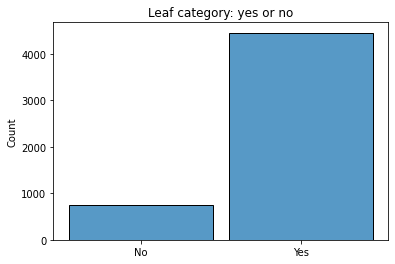

In [34]:
leaf_categ = df_categ.groupby('leaf')['category_id'].agg(['count'])
leaf_categ['perc'] = leaf_categ.values * 100 / len(df_categ.leaf)

print('Является ли категория конечной:\n', round(leaf_categ, 2))

ax = sns.histplot(data = df_categ, 
             x = 'leaf', 
             bins = 2, 
             shrink = .9,
             discrete = True)

plt.title('Leaf category: yes or no')
ax.set(xlabel = None)
ax.set_xticks([0,1])
ax.set_xticklabels(['No','Yes'])

plt.show()

Большинство категорий являются конечными и их можно использовать для создания продукта - около 86% приходится на конечные категории и 14% на конечные. 

<b> Посмотреть сколько приходится category_id на наименование категорий.</b> 

In [35]:
cat_id_name = df_categ.groupby('name')['category_id'].count()
cat_id_name.describe()

count    4361.000000
mean        1.195139
std         0.899406
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: category_id, dtype: float64

В среднем на одно наименование приходится по 1,2 category_id. Видно, что имеются выбросы в сторону максимума. Зато минимум и вплоть до 3 квартиля все равно единице.

<b>Посмотреть кол-во обязательных атрибутов и соотношение обязательный / необязательный, стандартные / нестандартные.</b>

In [36]:
df.groupby('is_mandatory')['id'].count()

is_mandatory
0    29930
1    10561
Name: id, dtype: int64

Является ли атрибут обязательным:
               count   perc
is_mandatory              
0             29930  73.92
1             10561  26.08


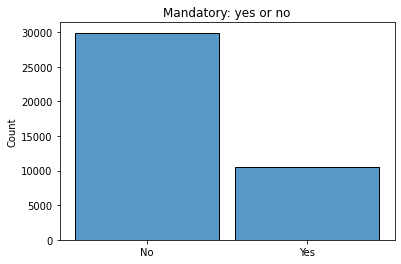

In [37]:
mandatory = df.groupby('is_mandatory')['id'].agg(['count'])
mandatory['perc'] = mandatory.values * 100 / len(df.is_mandatory)

print('Является ли атрибут обязательным:\n', round(mandatory, 2))

ax = sns.histplot(data = df, 
             x = 'is_mandatory', 
             bins = 2, 
             shrink = .9,
             discrete = True)

plt.title('Mandatory: yes or no')
#plt.xlabel('mandatory')
ax.set(xlabel = None)
ax.set_xticks([0,1])
ax.set_xticklabels(['No','Yes'])

#plt.xticks(rotation = 45)

plt.show()

Большинство атрибутов (около 74%) являются необязательными. Обязательными являются только 10к id - 26%.

Является ли атрибут стандартным атрибутом продажи:
               count   perc
is_sale_prop              
0             39037  96.41
1              1454   3.59


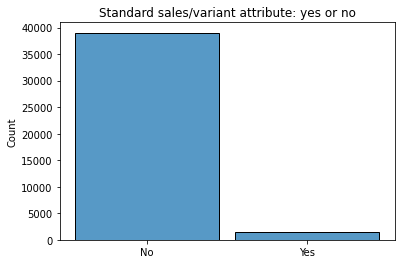

In [38]:
prop = df.groupby('is_sale_prop')['id'].agg(['count'])
prop['perc'] = prop.values * 100 / len(df.is_sale_prop)

print('Является ли атрибут стандартным атрибутом продажи:\n', round(prop, 2))

ax = sns.histplot(data = df, 
             x = 'is_sale_prop', 
             bins = 2, 
             shrink = .9,
             discrete = True)

plt.title('Standard sales/variant attribute: yes or no')
#plt.xlabel('mandatory')
ax.set(xlabel = None)
ax.set_xticks([0,1])
ax.set_xticklabels(['No','Yes'])

#plt.xticks(rotation = 45)

plt.show()

Стандартными атрибутами продажи являются только почти 4% от всех атрибутов.

<b>Вычислить соотношение типов атрибутов - normal / sku.</b>

In [39]:
df.attribute_type.unique()

array(['normal', 'sku'], dtype=object)

Типы атрибутов:
                 count   perc
attribute_type              
normal          21591  53.32
sku             18900  46.68


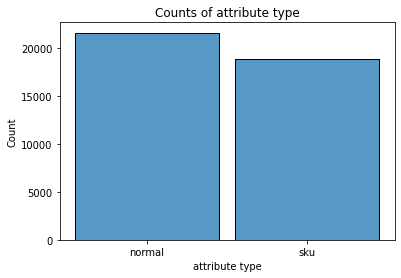

In [40]:
att_type = df.groupby('attribute_type')['id'].agg(['count'])
att_type['perc'] = att_type.values * 100 / len(df.attribute_type)

print('Типы атрибутов:\n', round(att_type, 2))

ax = sns.histplot(data = df, 
             x = 'attribute_type', 
             bins = 2, 
             shrink = .9)

plt.title('Counts of attribute type')
#plt.xlabel('mandatory')
ax.set(xlabel = 'attribute type')


#plt.xticks(rotation = 45)

plt.show()

<b>Вычислить и визулизировать общее кол-во и кол-во уникальных id по типам значений, которые для него можно ввести (input_type).</b>

Типы входных данных:
                 count  nunique   perc
input_type                           
singleselect     9800       90  24.20
numeric          9324       56  23.03
text             7594       39  18.75
enuminput        2823      406   6.97
richtext         2764       73   6.83
date             2575        4   6.36
multienuminput   2067      115   5.10
img              1997        3   4.93
multiselect      1502       12   3.71
nan                45        1   0.11


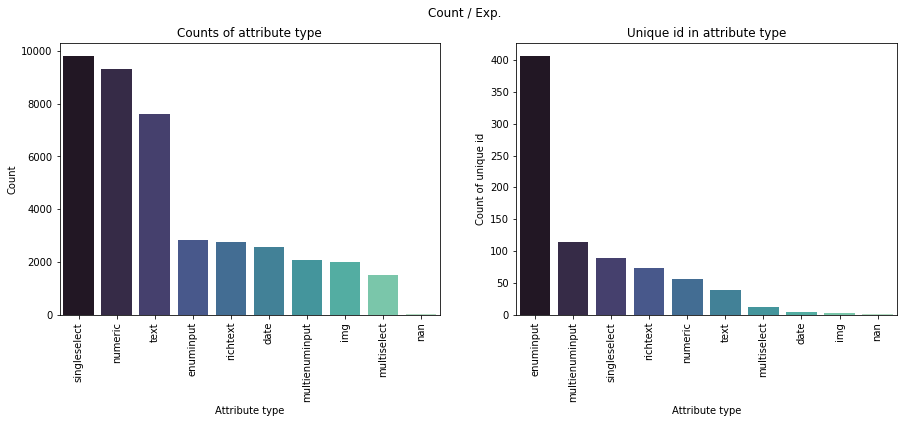

In [41]:
input_type = df.groupby('input_type')['id'].agg(['count', 'nunique'])
input_type['perc'] = input_type['count'] * 100 / len(df.input_type)

print('Типы входных данных:\n', round(input_type.sort_values(by='perc', ascending=False), 2))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Count / Exp.')

sns.barplot(ax=axes[0],
                 data = df,
                 x = df.groupby('input_type')['id'].count().sort_values(ascending=False).index, 
                 y = df.groupby('input_type')['id'].count().sort_values(ascending=False).values,
                 palette='mako')

axes[0].set_title('Counts of attribute type')
axes[0].set(xlabel = 'Attribute type',
        ylabel = 'Count')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1],
                 data = df,
                 x = df.groupby('input_type')['id'].nunique().sort_values(ascending=False).index, 
                 y = df.groupby('input_type')['id'].nunique().sort_values(ascending=False).values,
                 palette='mako')

axes[1].set_title('Unique id in attribute type')
axes[1].set(xlabel = 'Attribute type',
        ylabel = 'Count of unique id')
axes[1].tick_params(axis='x', rotation=90)

plt.show()

Больше всего id приходится на входные типы - singleselect - одиночный выбор, который не поддерживает настройку - 24%.

Потом идет - numeric (23%) и text (19%) - числовое и тесктовое значения, которые поддерживают настройку. Всех остальных менее 10%. 

Но если посмотреть значения для уникальных id, которые приходятся на каждый тип, то видно, что: 

максимум у enuminput - одиночный выбор, который поддерживает настройку - 406 id, multienuminput - множественный выбор, который тоже поддерживает настройку - 115 id. Для всех остальных типов входгых данных кол-во уникальных id меньше 100.

<b>Посмотреть сколько приходится имен атрибутов на лейбл, на id атрибута.</b>

In [42]:
print('Кол-во уникальных id:', df.id.nunique())
print('Кол-во уникальных name:', df.name_attribute.nunique())
print('Кол-во уникальных label:', df.label.nunique())

Кол-во уникальных id: 677
Кол-во уникальных name: 673
Кол-во уникальных label: 641


Уникальных имен на 4 меньше, чем айди, посмотрю какому имени соответствует два айди.

Лейблов меньше, чем имен, значит одному лейблу может соответствовать несколько имен. Посмотрю так ли это и что это за имена.

In [43]:
df.groupby('name_attribute')['id'].nunique().sort_values(ascending=False).head(10)

name_attribute
volume                2
connectivity          2
cable_length          2
scent                 2
occasion              2
__images__            1
ring_size             1
reinforced_toe_cap    1
replacement_type      1
resolution            1
Name: id, dtype: int64

Получается 5 именам атрибутов соответствует 2 id - volume, connectivity, cable_length, scent, occasion. Все остальное по одному.

In [44]:
df.query('name_attribute == "volume"').head()

,attribute_type,category_id,id,input_type,is_mandatory,is_sale_prop,label,name_attribute,name_category
669,normal,1468,30637,numeric,0,0,volume (ml),volume,aromatherapy
724,sku,1478,30637,numeric,0,1,volume (ml),volume,body moisturizers
791,normal,1494,30637,numeric,0,0,volume (ml),volume,bronzers
877,normal,1507,30637,richtext,0,0,volume (ml),volume,bronzers
1050,sku,1605,30637,numeric,0,1,volume (ml),volume,shampoo


In [45]:
df.query('name_attribute == "volume"').id.unique()

array([    30637, 110003048], dtype=int32)

In [46]:
df.query('id == 110003048').head()

,attribute_type,category_id,id,input_type,is_mandatory,is_sale_prop,label,name_attribute,name_category
12775,sku,8784,110003048,numeric,0,1,volume,volume,powders
32180,sku,10002756,110003048,numeric,0,1,volume,volume,oils
32213,sku,10002757,110003048,numeric,0,1,volume,volume,powders
32245,sku,10002759,110003048,numeric,0,1,volume,volume,body wash


In [47]:
df.query('id == 110003048').label.unique()

array(['volume'], dtype=object)

In [48]:
df.query('id == 30637').label.unique()

array(['volume (ml)'], dtype=object)

Например, volume - если более детально рассмотреть данное имя атрибута, то видно, что для разных id, соответствуют разные label, т.е. данные значения нельзя считать повторами в полной мере и, например, заменить одно на другое. 

Далее проверю как соотносятся label и name_attribute.

In [49]:
print('Кол-во label, которым соотверствует более одного name_attribute:', 
      len(df.groupby('label')['name_attribute'].nunique().sort_values(ascending=False)[lambda x: x>1]))

df.groupby('label')['name_attribute'].nunique().sort_values(ascending=False)[lambda x: x>1]

Кол-во label, которым соотверствует более одного name_attribute: 22


label
product form               5
material                   5
size                       4
flavor                     3
sleeve length              3
cable type                 3
accessory type             3
ingredient                 2
features                   2
pattern                    2
scent                      2
neckline                   2
recommended age            2
warranty                   2
volume                     2
types of dim sum           2
swimwear style             2
waterproof                 2
occasion                   2
pack type                  2
air humidifier features    2
color                      2
Name: name_attribute, dtype: int64

Далее проверю их более подробно. Ну можно сказать, что это одно и тоже, только со своими параметрами.

In [50]:
df.query('label == "product form"').name_attribute.unique()

array(['fmlt_face_makeup', 'formulation_hair_color', 'fmlt_skin_care',
       'formulation_supplement', 'product_form'], dtype=object)

In [51]:
df.query('label == "material"').name_attribute.unique()

array(['material_type', 'material', 'fabrics', 'kid_material_filter',
       'curtain_material'], dtype=object)

In [52]:
df.query('label == "size"').name_attribute.unique()

array(['size_class', 'size', 'size_baby_clothing', 'size_baby_shoes'],
      dtype=object)

Так как id и label тоже близкое кол-во, то посмотрю как они между собой соотносятся и мб там есть скрытые дубли.

In [53]:
df.groupby('id')['label'].nunique().sort_values(ascending=False).head(10)

id
26       2
1        1
90121    1
90123    1
90127    1
90129    1
90130    1
90140    1
90142    1
90143    1
Name: label, dtype: int64

In [54]:
df.query('id == 26').label.unique()

array(['package width (cm)', 'car_cascade'], dtype=object)

Нет, говорить, что это дубли нельзя, значит стоит оставить это так.

В целом, можно сказать, что для однозначного определения значений атрибута достаточно трех значений - category_id, id и либо name_attribute, либо label.

In [55]:
df[['category_id', 'id']].duplicated().sum()

45

In [56]:
df[['category_id', 'id', 'name_attribute']].duplicated().sum()

0

In [57]:
df[['category_id', 'id', 'label']].duplicated().sum()

0

<b>Посмотреть сколько приходится id атрибутов на id категорий, посмотреть стат. данные, бостроить боксплот.</b>

In [58]:
df.category_id.nunique()

1286

Посмотрю сколько в среднем приходится на одну категорию id

In [59]:
cat_id_id = df.groupby('category_id')['id'].count()
cat_id_id.describe()

count    1286.000000
mean       31.486003
std         4.163698
min        25.000000
25%        29.000000
50%        31.000000
75%        34.000000
max        72.000000
Name: id, dtype: float64

Медианное значение и среднее почти совпадают, значит аномальных выбросов не так много.

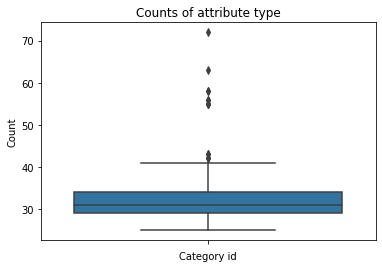

In [60]:
ax = sns.boxplot(y=cat_id_id.values)

plt.title('Counts of attribute type')
ax.set(xlabel = 'Category id',
      ylabel = 'Count')

plt.show()

## Вывод

Для выполнения работы было загружены из API Lazada два дф с данными из GetCategoryTree, который в дальнейшем был использован для данных из GetCategoryAttributes, по которому и делался основной анализ.

В ходе исследования установлено, что всего на Lazada представлено 5212 категорий, для удобства анализ производился для 1301 категории, которые подпадают под условие: в одно имя категории входит несколько category_id. В среднем на одно имя приходится 1,2 category_id, а значения с 1 по 3 квартиль равны единице. Максимальное кол-во category_id на одно имя - 31. 

После получения category_id, были выполнены запросы для них и получен  дф с данными из GetCategoryAttributes. Размерность полученного дф - 40490.

<b> Анализ показал, что:</b>

1. Большинство категорий являются конечными и их можно использовать для создания продукта - около 86% приходится на конечные категории и 14% на неконечные. 

2. Большинство атрибутов (около 74%) являются необязательными. Обязательными являются только 10к id - 26%.

3. Стандартными атрибутами продажи являются только почти 4% от всех атрибутов, все остальные под этот критерий не подпадают.

4. Большинство атрибутов - normal (53%), т.е. при создании или обновлении продукта надо заполнять поле "Attribute". А поле "Sku" заполняется у 47% атрибутов.

5. Больше всего id приходится на входные типы - singleselect - одиночный выбор, который не поддерживает настройку - 24%. Потом идет - numeric (23%) и text (19%) - числовое и текстовое значения, которые поддерживают настройку. На все остальные приходится менее 10% на каждый. Однако, если посмотреть значения для уникальных id, которые приходятся на каждый тип, то видно, что: максимум у enuminput - одиночный выбор, который поддерживает настройку - 406 id, multienuminput - множественный выбор, который тоже поддерживает настройку - 115 id. Для всех остальных типов входных данных кол-во уникальных id меньше 100.

6. После анализа можно сказать, что для однозначного определения значений атрибута достаточно трех значений их дф- category_id, id и либо name_attribute, либо label. Любых двух из них будет не хватать для однозначности.

7. В среднем на одну категорию приходится 31.5 id атрибута. Медианное значение (31) и среднее почти совпадают, значит аномальных выбросов не так много. Максимум - 74, минимум - 25.
